# Thema: Organisations-IDs für wissenschaftliche Einrichtungen anhand von Emailadressen gewinnen

### 1 Fragestellung
Die Aufgabe bestand darin, die Emailadressen den entsprechenden Institutionen zuzuordnen.

Die Datenquellen dafür waren:
 - GRID Open Data Dump https://figshare.com/articles/GRID_release_2018-11-14/7346852
(Darin sind Tabellen mit Informationen zu Institutionen, die jew. durch ihre Grid-Id identifiziert werden, sowie Akronyme, Adressen, andere Bezeichnungen für die Institutionen, weitere Ids, uvm. wie z.B. eine Datei, in der das Verhältnis der verschiedenen Institutionen zueinander verzeichnet ist, z.B. Institute, die ihrer Universität untergeordnet sind.)


 - die Datei guete_bearbeitet.csv, die im Rahmen unserer ersten Aufgabe zur Güte von Recall und Precision erstellt wurde.

### 2 Vorgehen
Aufgabe: Matching domains mit GRID Webseiten-URLs

Die Grundidee ist, mithilfe der Programmierbibliothek Pandas von Python passende Spalten aus den vielen verschiedenen Datenquellen per „Merge“ zusammenzustellen. So soll man am Ende die Emailadressen den Institutionen zuordnen können.

In [39]:
#pip install tldextract
import tldextract as tld
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from urllib.parse import urlparse

In [2]:
# Funktionen zum parsen der Url 
def extract_domain(link):
    link = tld.extract(link)
    return link.domain

def extract_suffix(link):
    link = tld.extract(link)
    return link.suffix

def extract_subdomain(link):
    link = tld.extract(link)
    return link.subdomain

def get_host(link):
    domain = extract_domain(link)
    suffix = extract_suffix(link)
    host = str(domain) + '.' + str(suffix)
    return host

In [3]:
# Einlesen der CSV-Dateien
bearbeitet = pd.read_csv('guete_bearbeitet.csv', index_col = 0)
institutes = pd.read_csv('institutes.csv', usecols=['grid_id','name'])
links = pd.read_csv('links.csv')
relationships = pd.read_csv('relationships.csv', usecols=['relationship_type', 'related_grid_id'])

Zunächst wurden die Dateien links und institutes" durch "merge" basierend auf der beiden gemeinsamen Spalte "grid_id" zusammengefügt in der neuen Datei name_and_link.

In [4]:
# merge institutes.csv mit links.csv
name_and_link = institutes.merge(links, on='grid_id')

In [5]:
# generieren der subdomain, domain, suffix und host
name_and_link['subdomain'] = name_and_link['link'].apply(extract_subdomain)
name_and_link['domain'] = name_and_link['link'].apply(extract_domain)
name_and_link['suffix'] = name_and_link['link'].apply(extract_suffix)
name_and_link['host'] = name_and_link['link'].apply(get_host)

# generieren des hosts für email
bearbeitet['mail_host'] = bearbeitet['email'].apply(get_host)

In [6]:
# exkludieren der child-Institute
child = relationships[relationships['relationship_type'] == 'Child']
child = name_and_link.merge(child, how='left', left_on='grid_id', right_on='related_grid_id')
#print(child.head(200))
parent = child[child.relationship_type != 'Child']
#print(parent.head(200))

In [7]:
print(parent.head())

       grid_id                            name                      link  \
0  grid.1001.0  Australian National University    http://www.anu.edu.au/   
1  grid.1002.3               Monash University    http://www.monash.edu/   
2  grid.1003.2        University of Queensland     http://www.uq.edu.au/   
3  grid.1004.5            Macquarie University         http://mq.edu.au/   
4  grid.1005.4                  UNSW Australia  https://www.unsw.edu.au/   

  subdomain  domain  suffix         host relationship_type related_grid_id  
0       www     anu  edu.au   anu.edu.au               NaN             NaN  
1       www  monash     edu   monash.edu               NaN             NaN  
2       www      uq  edu.au    uq.edu.au               NaN             NaN  
3                mq  edu.au    mq.edu.au               NaN             NaN  
4       www    unsw  edu.au  unsw.edu.au               NaN             NaN  


In [8]:
parent.to_csv('parent.csv')

In [9]:
matches_parent = pd.merge(bearbeitet, parent, how='left', left_on='mail_host', right_on='host')

In [10]:
print(matches_parent.head())

              email                                            tdm_url  \
0  meduniwien.ac.at  https://api.elsevier.com/content/article/PII:S...   
1  meduniwien.ac.at  https://api.elsevier.com/content/article/PII:S...   
2  meduniwien.ac.at  https://api.elsevier.com/content/article/PII:S...   
3  meduniwien.ac.at  https://api.elsevier.com/content/article/PII:S...   
4        bruker.com  http://link.springer.com/article/10.1007/s1183...   

                time_stamp    mine_method                          doi  \
0  2018-12-17 16:06:12 UTC   Elsevier XML  10.1016/j.ddtec.2014.03.009   
1  2018-12-17 16:06:12 UTC   Elsevier XML  10.1016/j.ddtec.2014.03.009   
2  2018-12-17 16:06:12 UTC   Elsevier XML  10.1016/j.ddtec.2014.03.009   
3  2018-12-17 16:06:12 UTC   Elsevier XML  10.1016/j.ddtec.2014.03.009   
4  2018-12-18 08:00:29 UTC  Springer HTML    10.1007/s11837-018-2752-0   

   recall  precision comment         mail_host        grid_id  \
0    True       True     NaN  meduniwien.ac.a

In [11]:
matches_parent = matches_parent.sort_values(by=['email']).reset_index(drop=True)

In [12]:
# durch die wegnahme der child_elemente konnten einige emails nicht gematcht werden. Dies wird im folgen Schritt behoben.
add_missings = matches_parent[matches_parent['grid_id'].isnull()]

In [13]:
add_missings = add_missings.drop(['subdomain', 'domain', 'suffix', 'host', 'grid_id', 'related_grid_id', 'name', 'link', 'relationship_type'], axis=1)
add_missings = add_missings.merge(name_and_link, how='left', left_on='mail_host', right_on='host')

In [14]:
add_missings = add_missings.drop_duplicates().reset_index(drop=True)

In [15]:
matches_parent = matches_parent[pd.notnull(matches_parent['grid_id'])]

In [16]:
matches_all = pd.concat([matches_parent, add_missings])
matches_all = matches_all.sort_values(by=['email']).reset_index(drop=True)

In [17]:
print(matches_all[['email', 'name']].head(10))

             email                                  name
0                                                    NaN
1                                                    NaN
2                                                    NaN
3                                                    NaN
4                                                    NaN
5          126.com                                   NaN
6      Outlook.com                                   NaN
7           aau.in         Anand Agricultural University
8  adm.cgmh.org.tw   Linkou Chang Gung Memorial Hospital
9  adm.cgmh.org.tw  Keelung Chang Gung Memorial Hospital


In [18]:
matches_all = matches_all[['email', 'tdm_url', 'time_stamp', 'mine_method', 'doi', 'recall', 'precision', 'comment', 'mail_host', 'grid_id', 'name', 'link', 'subdomain', 'domain', 'suffix', 'host']]

In [19]:
matches_all.to_csv('matches_all.csv')

In [37]:
# Annahme: hosts mit einer kürzeren subdomain sind Hauptakteure. Im folgenden werden die Institutionen mit der kürzesten subdomain gefiltert.
dataframes = []
for host in matches_all.host.unique():
    filter_host = matches_all[matches_all.host == host]
    filter_subdomain = filter_host['subdomain'].values
    min_length_subdomain = 100
    min_subdomain = ''
    for element in filter_subdomain:
        if len(element) < min_length_subdomain:
            min_length_subdomain = len(element)
            min_subdomain = element
        else:
            continue
    save_dataframe = filter_host[filter_host.subdomain == min_subdomain]
    dataframes.append(save_dataframe)
    

subdomain_dataframe = pd.concat(dataframes)
subdomain_dataframe = subdomain_dataframe.drop_duplicates().reset_index(drop=True)
print(subdomain_dataframe[['email', 'name']].head(10))

             email                                      name
0           aau.in             Anand Agricultural University
1  adm.cgmh.org.tw      Keelung Chang Gung Memorial Hospital
2  adm.cgmh.org.tw      Taoyuan Chang Gung Memorial Hospital
3  adm.cgmh.org.tw    Kaohsiung Chang Gung Memorial Hospital
4  adm.cgmh.org.tw       Chiayi Chang Gung Memorial Hospital
5  adm.cgmh.org.tw              Chang Gung Memorial Hospital
6  adm.cgmh.org.tw            Chang Gung Children's Hospital
7       agh.edu.pl  AGH University of Science and Technology
8           amc.nl                   Academic Medical Center
9       amc.uva.nl                   University of Amsterdam


In [38]:
# Annahme: paths von URLs mit einer kurzen Ordnerhierarchie und/oder einer index.html bzw. index.php datei weisen auf Hauptakteure einer Institution hin.
dataframes = []
for host in subdomain_dataframe.host.unique():
    filter_host = subdomain_dataframe[subdomain_dataframe.host == host]
    filter_link = filter_host['link'].values
    preferred_link = ''
    preferred_list = []
    hierarchy_count = 10
    for link in filter_link:
        parsed_url = urlparse(link)
        iterationen = parsed_url.path.count('/')
        if iterationen < hierarchy_count:
            preferred_link = link
            hierarchy_count = iterationen
        elif iterationen == hierarchy_count:
            preferred_list.append(link)
            hierarchy_count = iterationen
        else:
            continue
    
    preferred_list.append(preferred_link)

    for link in preferred_list:
        if link.endswith('html'):
            preferred_link = link
            break

        elif link.endswith('php'):
            preferred_link = link
            break

        else:
            preferred_link = link
    
    save_dataframe = filter_host[filter_host.link == preferred_link]
    dataframes.append(save_dataframe)
    

solution = pd.concat(dataframes)
solution = solution.drop_duplicates().reset_index(drop=True)
print(solution[['email', 'name']].to_string())

                          email                                               name
0                        aau.in                      Anand Agricultural University
1               adm.cgmh.org.tw               Keelung Chang Gung Memorial Hospital
2                    agh.edu.pl           AGH University of Science and Technology
3                        amc.nl                            Academic Medical Center
4                    amc.uva.nl                            University of Amsterdam
5                    amc.uva.nl                            University of Amsterdam
6                    amc.uva.nl                            University of Amsterdam
7                        uva.nl                            University of Amsterdam
8                        uva.nl                            University of Amsterdam
9                    amu.edu.pl               Adam Mickiewicz University in Poznań
10                wa.amu.edu.pl               Adam Mickiewicz University in Poznań
11  

In [22]:
solution = solution[['email', 'tdm_url', 'time_stamp', 'mine_method', 'doi', 'recall', 'precision', 'comment', 'mail_host', 'grid_id', 'name', 'link', 'subdomain', 'domain', 'suffix', 'host']]

In [23]:
solution.to_csv('solution.csv')

### 3 Ergebnisse
Viele E-Mailadressen konnten korrekt zugeordnet werden.

Problematisch für das Vorgehen sind logischerweise vor allem die Fälle, in denen die Forscher keine Emailadressen ihrer Institution angegeben haben, sondern Gmail, Yahoo oder ähnliches.

In [24]:
# Anzahl der gematchen emails
print(len(solution['doi'].unique()))

155


In [25]:
# Überprüfung ob nan elemente in solution stecken
solution['grid_id'].isnull().sum()

0

In [26]:
# Anzahl der nicht gematchen emails
matches_all['grid_id'].isnull().sum()

45

In [27]:
# Anzahl nicht angegebener emails
(matches_all['email'] == ' ').sum()

5

In [28]:
# Gesamtmenge(doppelte Emails included, nan Elemente enthalten)
print(len(matches_all))

504


In [29]:
# Gesamtmenge(alle "echte" Matches)
print(len(solution))

156


In [30]:
print((matches_all['grid_id'].isnull().sum()/len(matches_all['doi']))*100)

8.928571428571429


In [31]:
print(len(matches_all['name'].unique()))

400


In [32]:
print(len(matches_all['email'].unique()))

173


In [33]:
# Länge des ursprünglichen Datensatzes
print(len(matches_all['doi'].unique()))

200


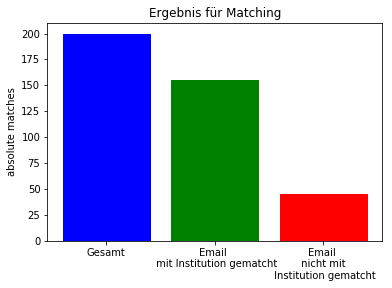

In [34]:
# Ergebnis für Matching
y_pos = ['Gesamt', 'Email \n mit Institution gematcht', 'Email \n nicht mit \n Institution gematcht']
x_pos = [len(matches_all['doi'].unique()),len(solution['doi'].unique()), matches_all['grid_id'].isnull().sum()]
barlist = plt.bar(y_pos, x_pos)
barlist[0].set_color('b')
barlist[1].set_color('g')
barlist[2].set_color('r')
plt.ylabel('absolute matches')
plt.title('Ergebnis für Matching')
plt.show()

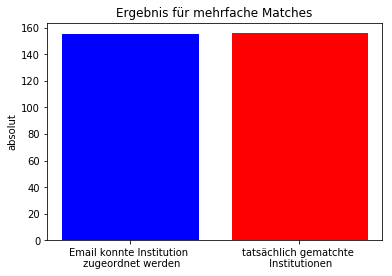

In [35]:
# Ergebnis für mehrfache Matches
y_pos = ['Email konnte Institution \n zugeordnet werden', 'tatsächlich gematchte \n Institutionen']
x_pos = [len(solution['doi'].unique()),len(solution)]
barlist = plt.bar(y_pos, x_pos)
barlist[0].set_color('b')
barlist[1].set_color('r')
plt.ylabel('absolut')
plt.title('Ergebnis für mehrfache Matches')
plt.show()
# keine merhfachen matches vorhanden

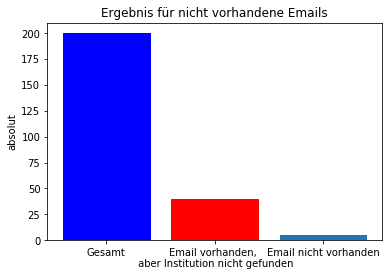

In [36]:
# Ergebnis für nicht vorhandene Emails
y_pos = ['Gesamt', 'Email vorhanden, \n aber Institution nicht gefunden', 'Email nicht vorhanden']
x_pos = [len(matches_all['doi'].unique()), matches_all['grid_id'].isnull().sum() - (matches_all['email'] == ' ').sum(),(matches_all['email'] == ' ').sum()]
barlist = plt.bar(y_pos, x_pos)
barlist[0].set_color('b')
barlist[1].set_color('r')
plt.ylabel('absolut')
plt.title('Ergebnis für nicht vorhandene Emails')
plt.show()

### 4 Diskussion

Die Annahmen, dass eine kürzere Subdomain und die Analyse eines kürzeren Hierarchiepfades einer Url tatsächlich auf die Hauptakteure einer Institution hinweisen, müssten stichprobenartig untersucht werden. 

### 5 Fazit
Insgesamt funktioniert das Vorgehen ganz gut, sodass relativ viele Emailadressen korrekt zugeordnet werden können.